In [1]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import matplotlib.pyplot as plt

from torch_geometric.utils import to_dense_adj, to_networkx, from_networkx

In [2]:
data = pd.ExcelFile(r"../data/NeuronConnect.xls") # use r before absolute file path 
data = data.parse(0)
data = data.rename(columns={'Neuron 1':'N1', 'Neuron 2':'N2','Nbr':'n_synapse', 'Type':'type'})
data = data[data['type'] != 'NMJ']
data = data[data['type'] != 'EJ']
data = data.drop(1870) # row with disconnected neurons 'avfl' and 'avfr' 
#data = data[data['n_synapse'] > 4 ]

Text(0, 0.5, 'count')

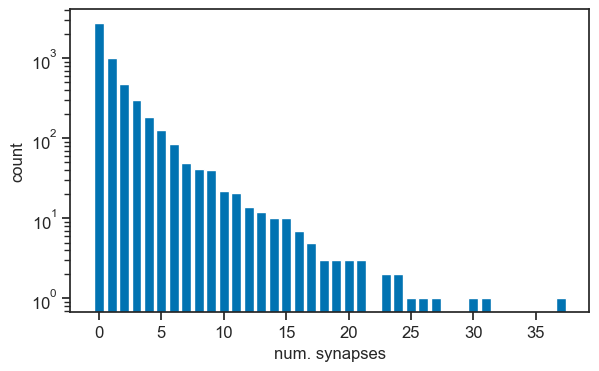

In [59]:
data.loc[data['n_synapse'] == 1]
x = np.unique(data['n_synapse'])
#data['n_synapse'].value_counts()
plt.bar(x, height=data['n_synapse'].value_counts())
plt.yscale('log')
plt.xlabel('num. synapses')
plt.ylabel('count')
#print(data[data['N1'] == 'avfl'])
#print(data[data['N2'] == 'avfr'])

In [5]:
location_data = pd.ExcelFile(r"../data/NeuronType.xls") # use r before absolute file path 
location_data = location_data.parse(0)
location_data = location_data.rename(columns={'Neuron':'neuron', 'Soma Position':'position'})
location_data = location_data[['neuron', 'position']]
location_dict = dict(location_data.to_numpy())

In [6]:
neuron_names = list(data['N1']) + list(data['N2']) 
neuron_names = set(neuron_names)
neuron_names_dict = {name : idx for idx, name in enumerate(neuron_names)}
n_neurons = len(neuron_names)
print(n_neurons)

279


In [7]:
# create a graph where all the edges in the dataset are included, except NMJ connections
G = nx.DiGraph()
G.add_nodes_from(range(n_neurons))

In [8]:
node_positions = {neuron_names_dict[neuron] : {'position' : location_dict[neuron]} for neuron in neuron_names}

In [9]:
nx.set_node_attributes(G, node_positions)

In [10]:
G.nodes[1]

{'position': 0.11}

In [11]:
neuron1 = data['N1'].to_numpy()
neuron2 = data['N2'].to_numpy()
synapse_type = data['type'].to_numpy()

for i in range(data.shape[0]):
    if synapse_type[i] == 'S' or synapse_type[i] == 'Sp':
        presynaptic = neuron1[i]
        postsynaptic = neuron2[i]
    if synapse_type[i] == 'R' or synapse_type[i] == 'Rp':
        presynaptic = neuron2[i]
        postsynaptic = neuron1[i]
    
    G.add_edge(neuron_names_dict[presynaptic], neuron_names_dict[postsynaptic]) 

num edges: 2194 num nodes: 279


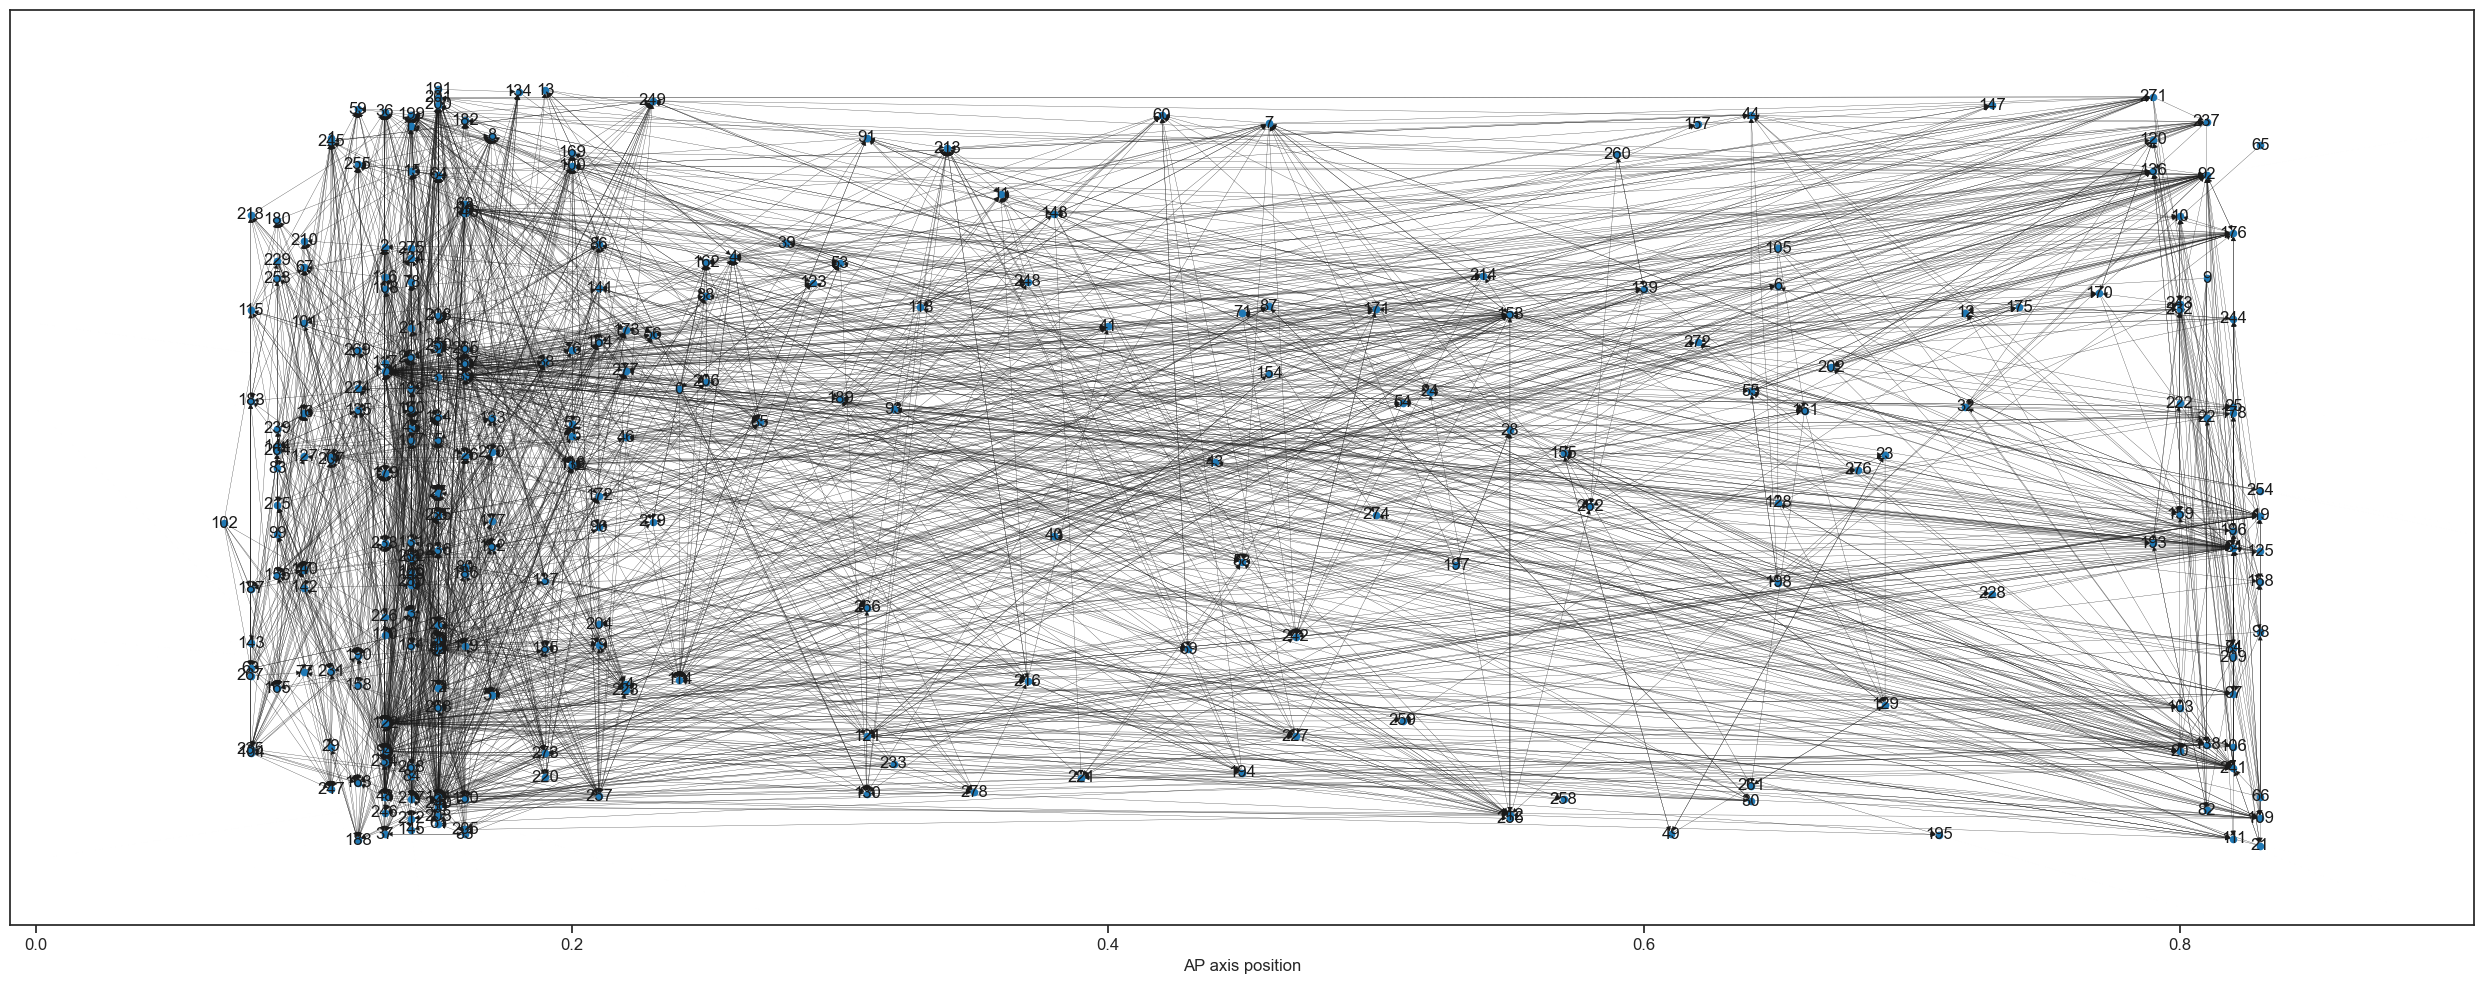

In [64]:
import seaborn as sns

sns.set_theme(palette="colorblind",style="ticks",context='notebook')

cm=1/2.54
params = {
    'legend.fontsize': 12,
    'font.size': 12,
    'figure.figsize': (17*cm,10.0*cm), # figsize for two-column latex doc
    'axes.labelsize': 12,
    'axes.titlesize': 12,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'lines.markersize': 3.0,
    'lines.linewidth': 1.5,
    }

plt.rcParams.update(params)


print(
'num edges:', G.number_of_edges(),
'num nodes:', G.number_of_nodes()
)

position_dict = nx.get_node_attributes(G, 'position')
xy_position_dict = dict()
for node in position_dict:
    y = np.random.random()
    x = position_dict[node]
    xy_position_dict[node] = np.array([x, y])

# visualisation of one of the networks generated
fig, ax = plt.subplots(figsize=(25,10))
nx.draw_networkx(
    G, arrows=True, with_labels=True, pos=xy_position_dict,arrowsize=8, node_size=200, width=0.2, ax=ax) 
ax.tick_params(axis='x', bottom=True, labelbottom=True)
#sns.despine()
ax.set_xlabel('AP axis position')
plt.tight_layout()
plt.savefig('../figures/c_elegans.pdf')

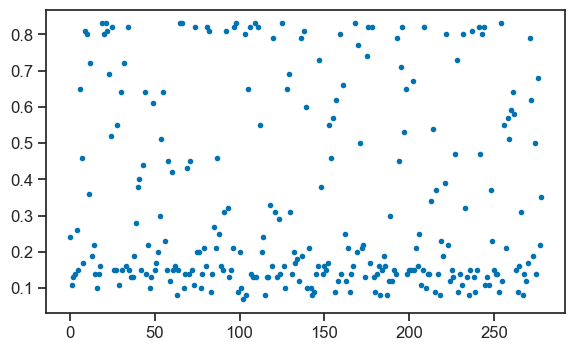

In [67]:
plt.plot(position_dict.keys(), position_dict.values(),'o')

In [60]:
G.number_of_nodes() / G.number_of_edges()

0.12716499544211485

In [101]:
n_edges = G.number_of_edges()

c_elegans_dataset = from_networkx(G)
c_elegans_dataset['W0'] = torch.zeros(n_edges)
n_inhibitory = n_edges - 1091 #n_edges // 2
n_excitatory = 1091 #n_edges - n_inhibitory
print(n_excitatory,n_inhibitory)
c_elegans_dataset.W0[:n_excitatory] = 1.5#torch.from_numpy(np.random.beta(a=2,b=2, size=n_excitatory)*2.)
c_elegans_dataset.W0[n_excitatory:] = -3.0#torch.from_numpy(np.random.beta(a=2,b=2, size=n_inhibitory)*(-3.*2))
example_network = c_elegans_dataset

print(example_network.W0.shape)
print(example_network.edge_index.shape)
print(example_network.num_nodes)
example_network

1091 1103
torch.Size([2194])
torch.Size([2, 2194])
279


Data(edge_index=[2, 2194], position=[279], num_nodes=279, W0=[2194])

In [104]:
c_elegans_dataset.W0

tensor([ 1.5000,  1.5000,  1.5000,  ..., -3.0000, -3.0000, -3.0000])

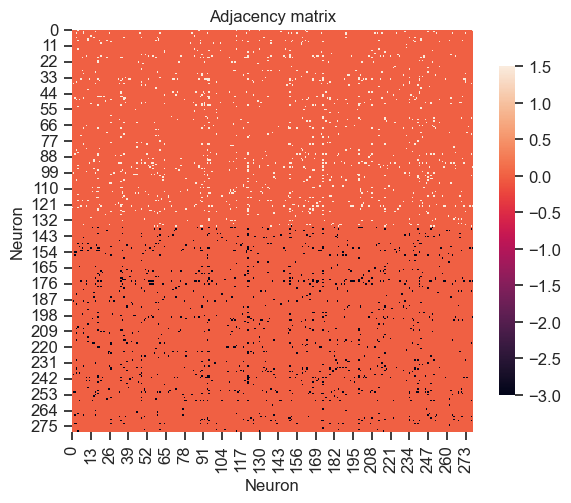

In [102]:
fig, ax = plt.subplots(figsize=(6,6))
#nx.draw_networkx(
#    G, arrows=True, ax=ax[0], node_color=node_color, pos=nx.circular_layout(G), node_size=150, width=0.8,arrowsize=10)
#ax[0].set_title("Full network")
#ax[0].set_aspect('equal', adjustable='box')

W0 = to_dense_adj(c_elegans_dataset.edge_index, edge_attr=c_elegans_dataset.W0, max_num_nodes=c_elegans_dataset.num_nodes)[0]
sns.heatmap(W0, ax=ax, annot=False,square=True,cbar_kws={"shrink": .6})
sns.despine(bottom = True, left = True, top=True,right=True)
ax.set_title("Adjacency matrix")
ax.set_xlabel("Neuron")
ax.set_ylabel("Neuron")
plt.tight_layout()
plt.savefig('../figures/rand_netw_20_nodes_p01.pdf')


In [111]:
279-137

142

In [112]:
torch.save(c_elegans_dataset, '../data/c_elegans_data.pt')

### Qualitative analysis of network structure

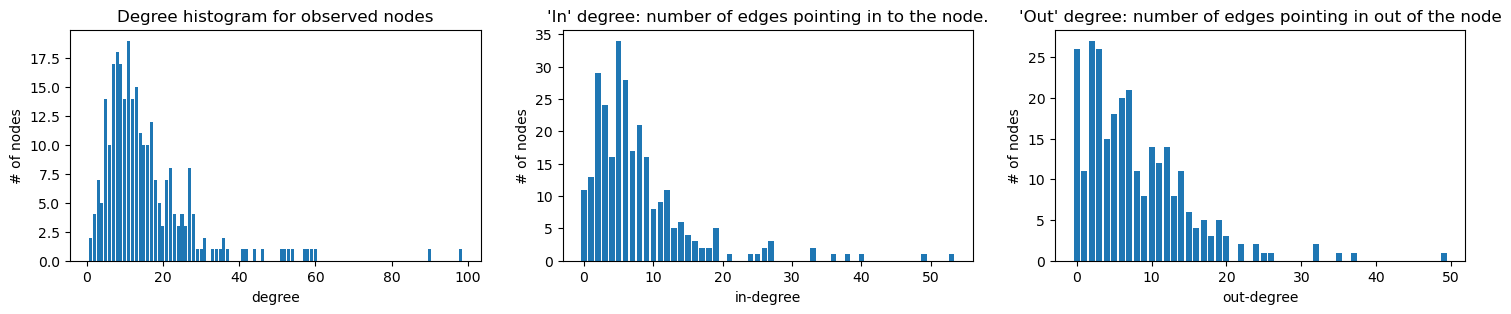

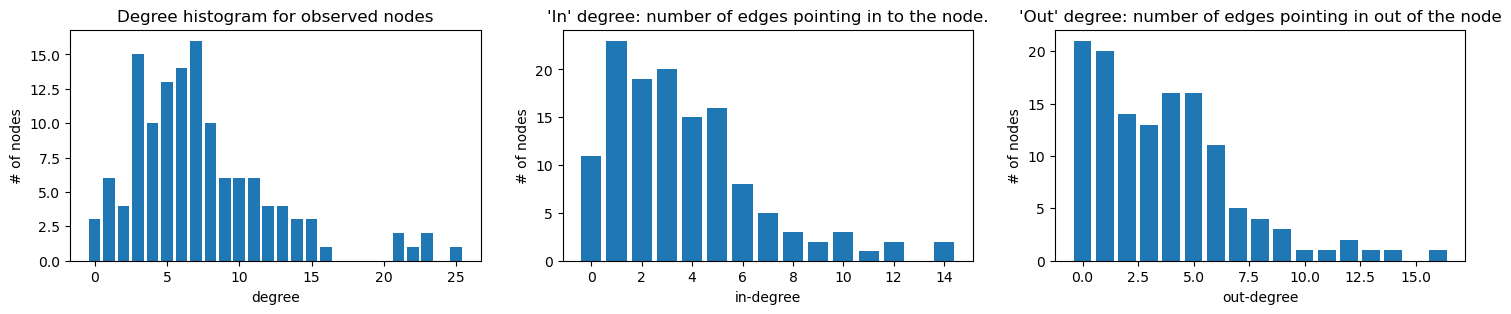

In [60]:
G_sub = nx.subgraph(G, np.arange(130))

fig, ax = plt.subplots(1, 3, figsize=(18, 3))
degree_sequence = sorted((d for n, d in G.degree()), reverse=True)
in_degree_sequence = sorted((d for n, d in G.in_degree()), reverse=True)
out_degree_sequence = sorted((d for n, d in G.out_degree()), reverse=True)

ax[0].bar(*np.unique(degree_sequence, return_counts=True))
ax[0].set_title("Degree histogram for observed nodes")
ax[0].set_xlabel("degree")
ax[0].set_ylabel("# of nodes")

ax[1].bar(*np.unique(in_degree_sequence, return_counts=True))
ax[1].set_title("'In' degree: number of edges pointing in to the node.")
ax[1].set_xlabel("in-degree")
ax[1].set_ylabel("# of nodes")

ax[2].bar(*np.unique(out_degree_sequence, return_counts=True))
ax[2].set_title("'Out' degree: number of edges pointing in out of the node")
ax[2].set_xlabel("out-degree")
ax[2].set_ylabel("# of nodes")
plt.show()



fig, ax = plt.subplots(1, 3, figsize=(18, 3))
degree_sequence = sorted((d for n, d in G_sub.degree()), reverse=True)
in_degree_sequence = sorted((d for n, d in G_sub.in_degree()), reverse=True)
out_degree_sequence = sorted((d for n, d in G_sub.out_degree()), reverse=True)

ax[0].bar(*np.unique(degree_sequence, return_counts=True))
ax[0].set_title("Degree histogram for observed nodes")
ax[0].set_xlabel("degree")
ax[0].set_ylabel("# of nodes")

ax[1].bar(*np.unique(in_degree_sequence, return_counts=True))
ax[1].set_title("'In' degree: number of edges pointing in to the node.")
ax[1].set_xlabel("in-degree")
ax[1].set_ylabel("# of nodes")

ax[2].bar(*np.unique(out_degree_sequence, return_counts=True))
ax[2].set_title("'Out' degree: number of edges pointing in out of the node")
ax[2].set_xlabel("out-degree")
ax[2].set_ylabel("# of nodes")
plt.show()

In [35]:
print(np.mean(degree_sequence), np.median(degree_sequence), np.std(degree_sequence))
print(np.mean(in_degree_sequence), np.median(in_degree_sequence),np.std(in_degree_sequence))
print(np.mean(out_degree_sequence), np.median(out_degree_sequence),np.std(out_degree_sequence))

15.727598566308243 12.0 12.628592677510754
7.863799283154122 6.0 7.520777521375099
7.863799283154122 6.0 6.962990842980192


In [61]:
for node, degree in G.in_degree():
    if degree > 40:
        print(node)

146
188


In [46]:
print(G.in_degree(0), G.in_degree(6), G.in_degree(12))

33 33 38


In [53]:
lst = [0,5,6].pop([0,5,6].index(5))
lst

5